# Prediction Performance Report

## Intro / How to Use this Notebook

Run this report from inside path *gridcure/predictions/[whichever-predictions-folder]* to get report charts for that set of predictions. 

This report contains the charts and statistics that I am using to evaluate the performance of my predictions of EV-charging by-house-by-time-interval (Question B. in Electric-Vehicle-Detection.docx).  

In this report, 'test set' refers to labeled data from EV_train.csv, held out from the entire model-building process.

## Table of Contents

1. Final Model Feature Importances 
2. Performance of Probability-Estimate Predictions
    1. Total EVs Charging by Interval
    2. Total EV Charging Intervals by House 
3. Performance of Binary Predictions
    1. Confusion Matrix (normalized). Accuracy/F-score
    2. Total EVs Charging by Interval
    3. Total EV Charging Intervals by House

## Load Libraries and Model Outputs

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score
plt.style.use('classic')

In [2]:
#Read in prediction outputs
train_preds = pd.read_csv('train_preds.csv')
train_Y     = pd.read_csv('train_Y.csv')
test_preds  = pd.read_csv('test_preds.csv')
test_Y      = pd.read_csv('test_Y.csv')

feature_importances = pd.read_csv('feature_importances.csv')

## Section 1: Feature-Importance

In [92]:
print(feature_importances)

                           Feature  XGB Reported Importance
0         observed Delta Hours 0.5                      336
1                         observed                      314
2             mean_charge_by_intvl                      273
3          observed Delta Hours 24                      206
4           observed Delta Hours 1                      146
5                    Mean observed                      143
6           observed Delta Hours 2                      130
7          observed Delta Hours 12                      123
8   StDev observed Delta Hours 0.5                       99
9         observed Delta Hours 1.5                       89
10   StDev observed Delta Hours 24                       76
11    Mean observed Delta Hours 24                       71
12                  StDev observed                       68
13           Predicted EV by House                       66
14   Mean observed Delta Hours 0.5                       63
15    StDev observed Delta Hours 1      

## Section 2. Performance of Probability-Estimate Predictions


### Figure 2.A: Predicted vs Actual Charging State; Total by Interval

In [3]:
def plot_EVs_sum_by_interval(ax, labels_true, labels_pred, group_columns, title = '', plot_intvls=1600):
    '''Compare Pred vs Actual(labels)... Total EVs Charging by Interval'''
    
    #Input Validation
    assert type(labels_true) == pd.Series
    assert type(labels_pred) == pd.Series
    assert type(group_columns) in (pd.Series, pd.DataFrame)    
    assert labels_true.shape[0] == labels_pred.shape[0] == group_columns.shape[0]

    #Pd Series Name will be Variable-Name to sum() by in DF.groupby() statement later
    varname_true = labels_true.name if labels_true.name != None else "EVs_Actual"
    varname_pred = labels_pred.name if labels_pred.name != None else "EVs_Predicted"
        
    #Column-bind Grouping Info into both True/Pred Series'
    df_true = pd.concat([group_columns, labels_true], axis=1)
    df_pred = pd.concat([group_columns, labels_pred], axis=1)
    
    #Group preds/actual by Interval
    true_EV_by_intvl = df_true.groupby('Interval')[varname_true].sum()
    pred_EV_by_intvl = df_pred.groupby('Interval')[varname_pred].sum()
    
    #Plot lines
    ax.plot(pred_EV_by_intvl[0:plot_intvls], color = 'blue', label='Predicted')
    ax.plot(true_EV_by_intvl[0:plot_intvls], color = 'green', label='Actual')
    
    #Calculate Mean Absolute Error, add as text box in chart
    errors = pred_EV_by_intvl - true_EV_by_intvl
    mean_abs_error = round(abs(errors).mean(),1)
    
    plt.text(0.05, 0.9, 'Mean Abs Error: ' + str(mean_abs_error), transform=ax.transAxes) 
    
    #Finish Setting Plotting Aesthetics
    ax.set_title(title)
    ax.set_ylabel('Sum of EVs Charging')
    ax.legend(loc='upper right') #best

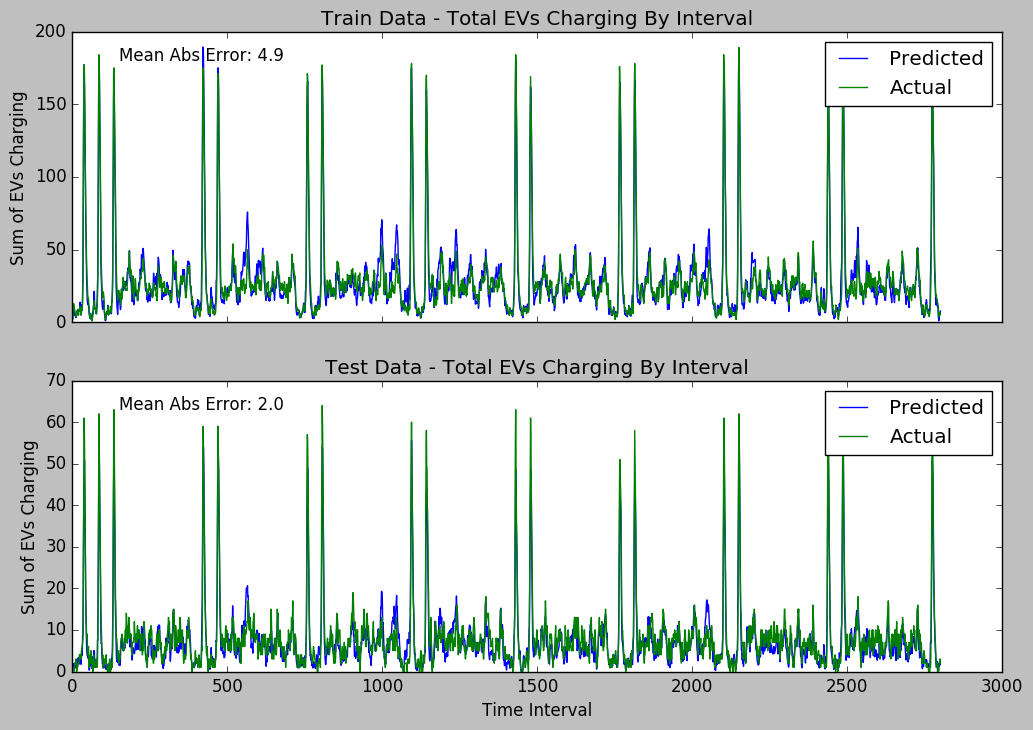

In [7]:
#Define a figure and its contained axes objects for 1x2 subplot
plt.gcf().clear()
fig2, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

#Plot Actual vs Predicted EVs by Interval, for train and test on ax1, ax2
#FOR PROBABILITY PREDICTIONS
plot_EVs_sum_by_interval(ax1, labels_true  = train_Y['EV Charging Flag'],
                              labels_pred  = train_preds['EV Charging Flag'],
                              group_columns= train_Y['Interval'], 
                              plot_intvls=2800, 
                              title='Train Data - Total EVs Charging By Interval')


plot_EVs_sum_by_interval(ax2, labels_true  = test_Y['EV Charging Flag'],
                              labels_pred  = test_preds['EV Charging Flag'],
                              group_columns= test_Y['Interval'], 
                              plot_intvls=2800, 
                              title='Test Data - Total EVs Charging By Interval')

#Set x-label outside of plot_EVs() so can set it only on bottom plot. Otherwise appears cluttered
ax2.set_xlabel('Time Interval')

plt.show()    

### Figure 2.B: Predicted vs Actual Charging state, by House

In [8]:
def plot_by_house(axes, labels_true, labels_pred, group_columns, house_subplots=5, 
                  plot_intervals=1600, title_prefix = 'Train or Test???', 
                  random_state=42):
    '''For a subset of houses(subplots), 
        plot two lines(pred/actual) as either charging-or-not(y) by interval(x)'''
    
    #Input Validation
    assert type(labels_true) == pd.Series
    assert type(labels_pred) == pd.Series
    assert type(group_columns) in (pd.Series, pd.DataFrame)    
    assert labels_true.shape[0] == labels_pred.shape[0] == group_columns.shape[0]

    #Rename true/pred Series' because may each be input with same name e.g. ('EV Flag')
    #(i.e. kept in different DFs but with same column name)
    labels_true.name = "Actual EV State"
    labels_pred.name = "Predicted EV State"
        
    #Column-bind pred/truth/group-vars into a DF. Should not change num rows
    df = pd.concat([group_columns, labels_true, labels_pred], axis=1)   
    assert df.shape[0] == labels_true.shape[0]
        
    #Filter df down to 'house_subplots' number of houses (change random_state for diff batch)
    random.seed(random_state)
    house_ids = random.sample(list(df['House ID'].unique()), house_subplots)
    df_sample = df.loc[df['House ID'].isin(house_ids)]# & df['Interval'] < plot_intervals]
    
    #Plot Predicted and Actual 'EV Charging' by Interval. One House per Subplot
    for idx, house in enumerate(df_sample['House ID'].unique()):
        df_one_house = df_sample[df_sample['House ID'] == house]
        df_one_house.plot('Interval', 'Actual EV State', kind='scatter', ax=axes[idx], color='green', label = 'Actual EV State')#, alpha=0.5)
        df_one_house.plot('Interval', 'Predicted EV State', kind='line', ax=axes[idx], color='blue', label = 'Predicted EV State')#, alpha=0.5)
        #Set plot labels/ticks
        axes[idx].set_ylim(0,1.8)
        axes[idx].set_yticks([0, 0.5, 1])
        axes[idx].set_xlim(0,plot_intervals)
        axes[idx].set_ylabel('Is EV Charging?')
        axes[idx].set_title(title_prefix + ' House: ' + str(house))
        #axes[idx].legend(loc='upper right')
        #Calc predicted and actual charging intervals by house. Add to plot
        total_pred = df_one_house['Predicted EV State'].sum()
        total_actual=df_one_house['Actual EV State'].sum()
        axes[idx].text(100, 1.2, s='Actual Total Charging Intervals: {:.0f} \nPredicted Total Charging Intervals: {:.0f}'.format(
            total_actual, total_pred)) 

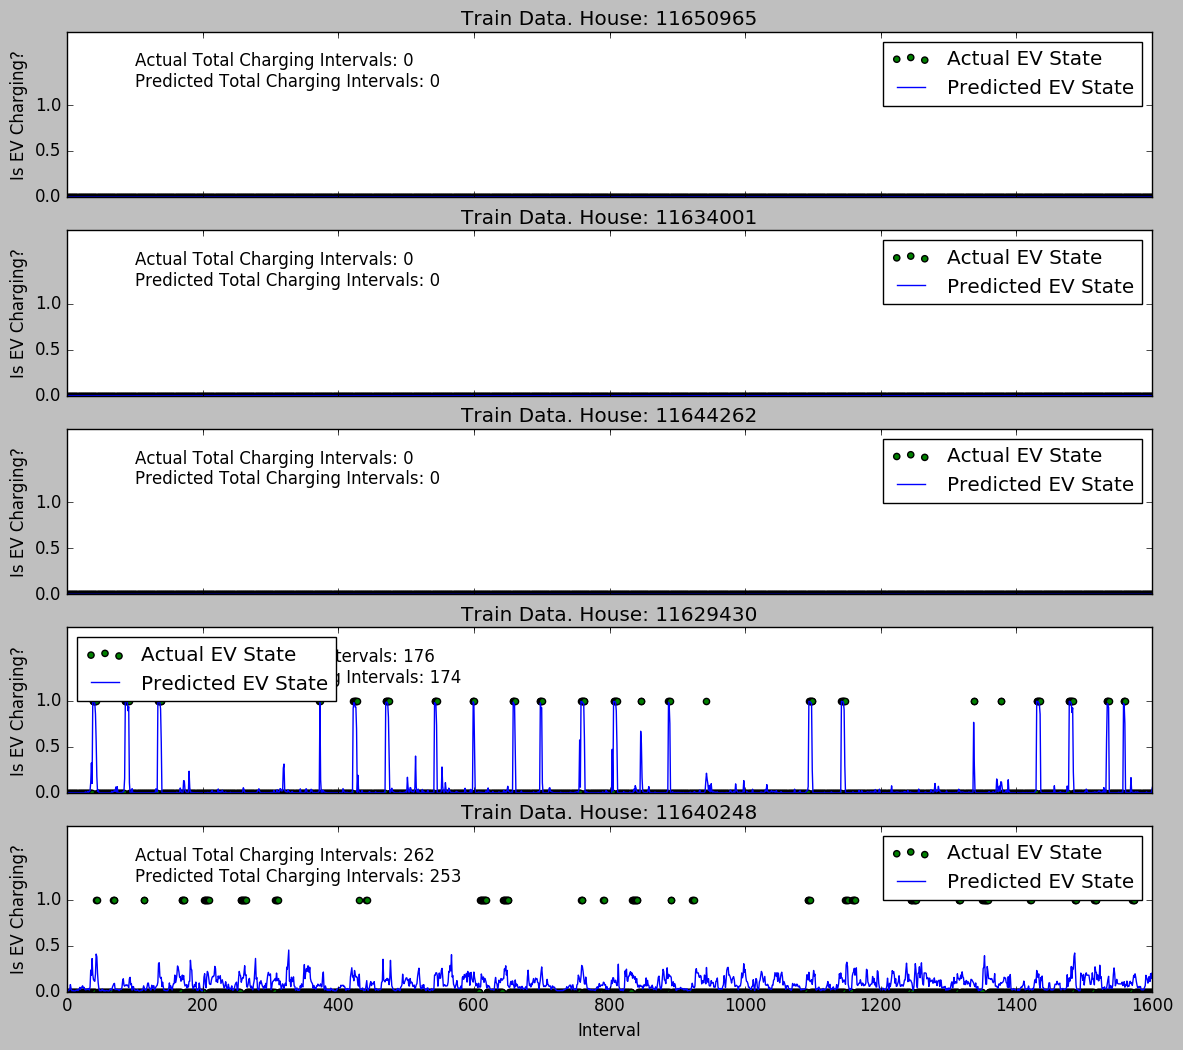

In [9]:
#TRAIN DATA - plot pred vs actual over time, for 5 houses
plt.gcf().clear()
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(14, 12))

#Plot train subplots. Change random seed to get different batch of houses
plot_by_house(axes, 
              labels_true=train_Y['EV Charging Flag'],
              labels_pred=train_preds['EV Charging Flag'],
              group_columns=train_preds[['Interval', 'House ID']],
              house_subplots=5,
              plot_intervals=1600, 
              title_prefix='Train Data.',
              random_state = 42)
plt.show()

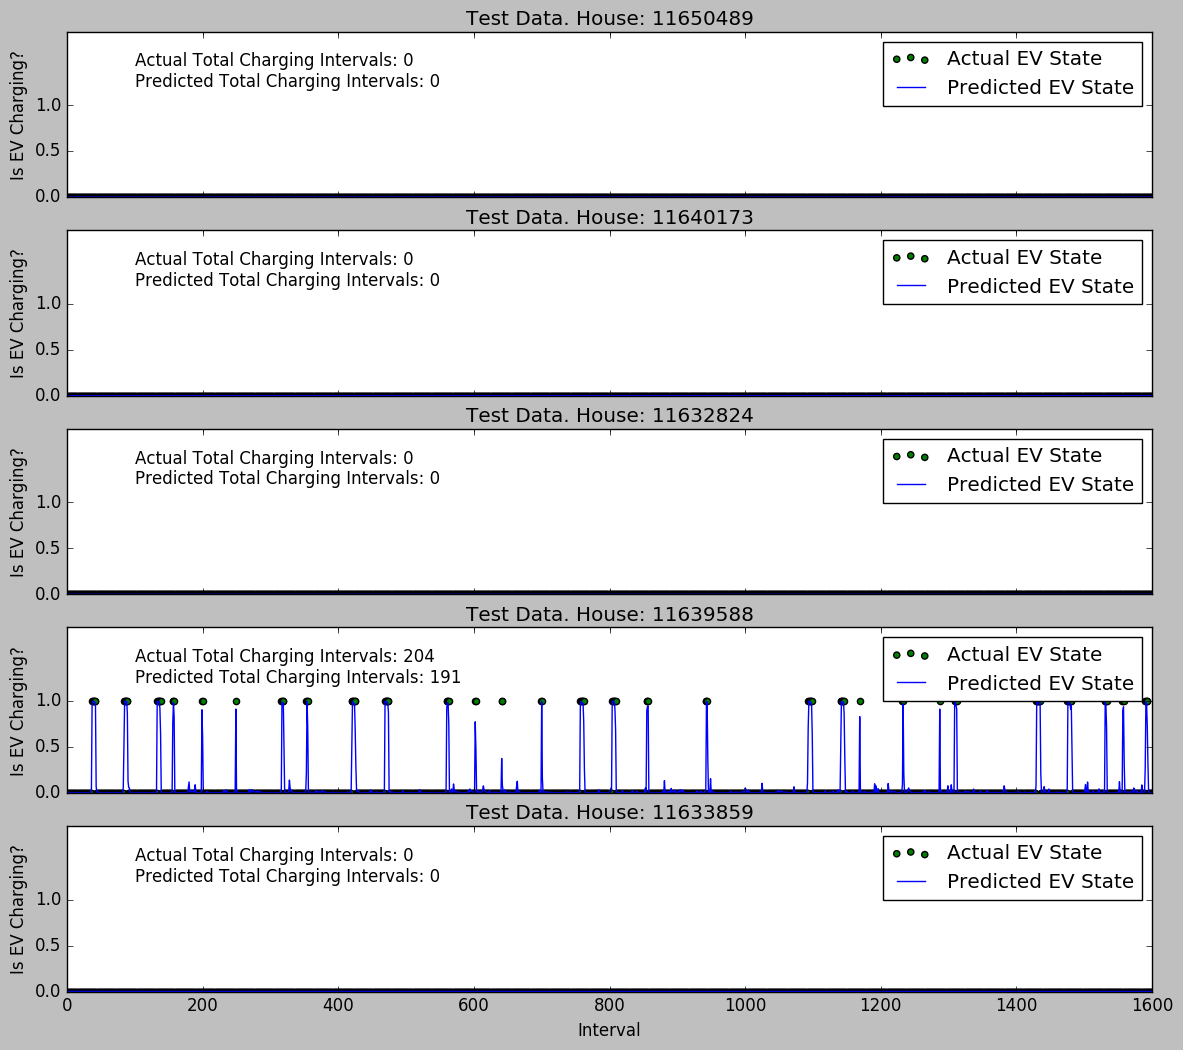

In [10]:
#TEST DATA - plot pred vs actual over time, for 5 houses
plt.gcf().clear()
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(14, 12))

#Plot train subplots. Change random seed to get different batch of houses
plot_by_house(axes, 
              labels_true=test_Y['EV Charging Flag'],
              labels_pred=test_preds['EV Charging Flag'],
              group_columns=test_preds[['Interval', 'House ID']],
              house_subplots=5,
              plot_intervals=1600, 
              title_prefix='Test Data.',
              random_state = 42)
plt.show()

## Section 3.  Performance of Class Predictions

### Figure 3.A. Confusion Matrix and Selected Classification Stats

In [13]:
import itertools
from sklearn.metrics import accuracy_score, f1_score
def pretty_print_conf_matrix(y_true, y_pred, ax=None, class_labels=['0','1'], normalize=True, title='title'):
    """
    Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
        
    
    
    params
    ------
    y_true: 1d array of ground-truth classes
    y_pred: 1d array of predicted classes
    ax:     "just plot it" if ax=None, otherwise return ax (subplot) object to caller    
        
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with color-scale and associated metrics.
    """
    
    C = confusion_matrix(y_true, y_pred)
    assert C.shape == (2,2), "Confusion matrix should be for binary classification only."

    # If user did not pass an axis (subplot) to plot on, initialize one here to
    if ax==None:
        fig, ax = plt.subplots()

    # Use plt.sca to set the current axes(subplot) for the pyplot state machine
    # (allows me to use slightly more convenient plt. funcs instead of ax. funcs)
    plt.sca(ax)

    # this block of code taken directly from sklearn example linked aove    
    plt.imshow(C, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=18)
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, fontsize=16) #rotation=45
    plt.yticks(tick_marks, class_labels, fontsize=16)
    #plt.tick_params(axis=u'both', which=u'both',length=0)
    #plt.setp(ax.get_xmajorticklabels(), visible=False)


    # I normalize so that all four cells of confusion matrix sum to 100%
    if normalize:
        C = np.round(C / C.sum(), 3)
        #C = pd.DataFrame(C/float(np.sum(C))).applymap(lambda x: '{:.1%}'.format(x)).values #np.round(C.astype('float') / C.sum(), 3)
        
        
    # Back to copying sklearn code 
    thresh = C.max() / 2.
    for i, j in itertools.product(range(C.shape[0]), range(C.shape[1])):
        plt.text(j, i, C[i, j],
                 horizontalalignment="center",
                 color="white" if C[i, j] > thresh else "black",
                 fontsize=16)
                 
    # Add Accuracy, F-1 Score as Captions Below Plot
    accuracy = accuracy_score(y_true, y_pred)                 
    fscore = f1_score(y_true, y_pred)
   
    plt.annotate('Accuracy is {:.3f}, \n F1-Score is {:.3f}'.format(accuracy, fscore), 
                 (0,0), (0, -80), 
                 xycoords='axes fraction', textcoords='offset points',
                 fontsize=14, ha='left')    
            
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)
       
    # Return subplot axis plot commands have been drawing on
    return ax


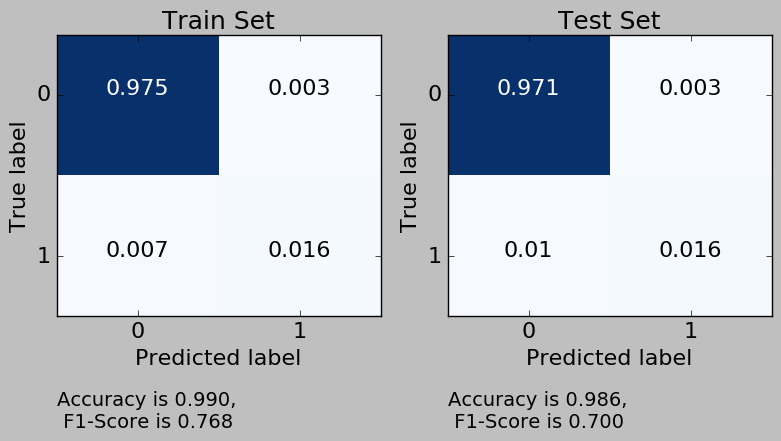

In [14]:
# Set classification threshold (future work could include tuning this with a validation set)
classification_threshold = 0.5

#Initialize figure/plots(axes) objects
plt.gcf().clear()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(8, 4))

#Plot train, test confusion matrices side-by-side
pretty_print_conf_matrix(train_Y['EV Charging Flag'], 
                         train_preds['EV Charging Flag'] > classification_threshold, 
                         ax1,
                         title='Train Set', normalize=True)

pretty_print_conf_matrix(test_Y['EV Charging Flag'], 
                         test_preds['EV Charging Flag'] > classification_threshold, 
                         ax2,
                         title='Test Set', normalize=True)


plt.tight_layout()
plt.show()

### 2.C. Total EVs Charging By Interval (Binary Predictions)

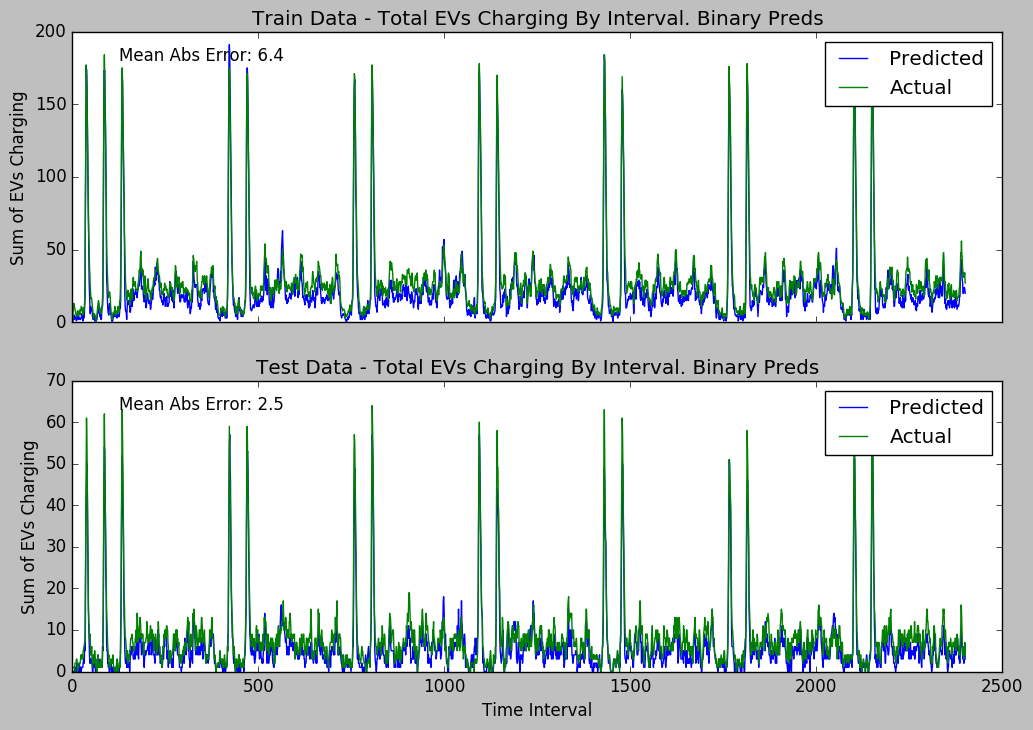

In [15]:
plt.gcf().clear()
fig2, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

plot_EVs_sum_by_interval(ax1, labels_true  = train_Y['EV Charging Flag'],
                              labels_pred  = train_preds['EV Charging Flag']>classification_threshold,
                              group_columns= train_Y['Interval'], 
                              plot_intvls=2400, 
                              title='Train Data - Total EVs Charging By Interval. Binary Preds')


plot_EVs_sum_by_interval(ax2, labels_true  = test_Y['EV Charging Flag'],
                              labels_pred  = test_preds['EV Charging Flag']>classification_threshold,
                              group_columns= test_Y['Interval'], 
                              plot_intvls=2400, 
                              title='Test Data - Total EVs Charging By Interval. Binary Preds')

#Set x-label outside of plot_EVs() so can set it only on bottom plot. Otherwise appears cluttered
ax2.set_xlabel('Time Interval')

plt.show()    

#### Takeaways:
Nice, Mean Abs Error of total EVs by Interval went down by 0.6 in the train data and 0.1 in the test data, after converting my estimator's probability estimates to 0/1 predictions.

### 2.D. Total EV Charging Intervals by House, Binary Predictions

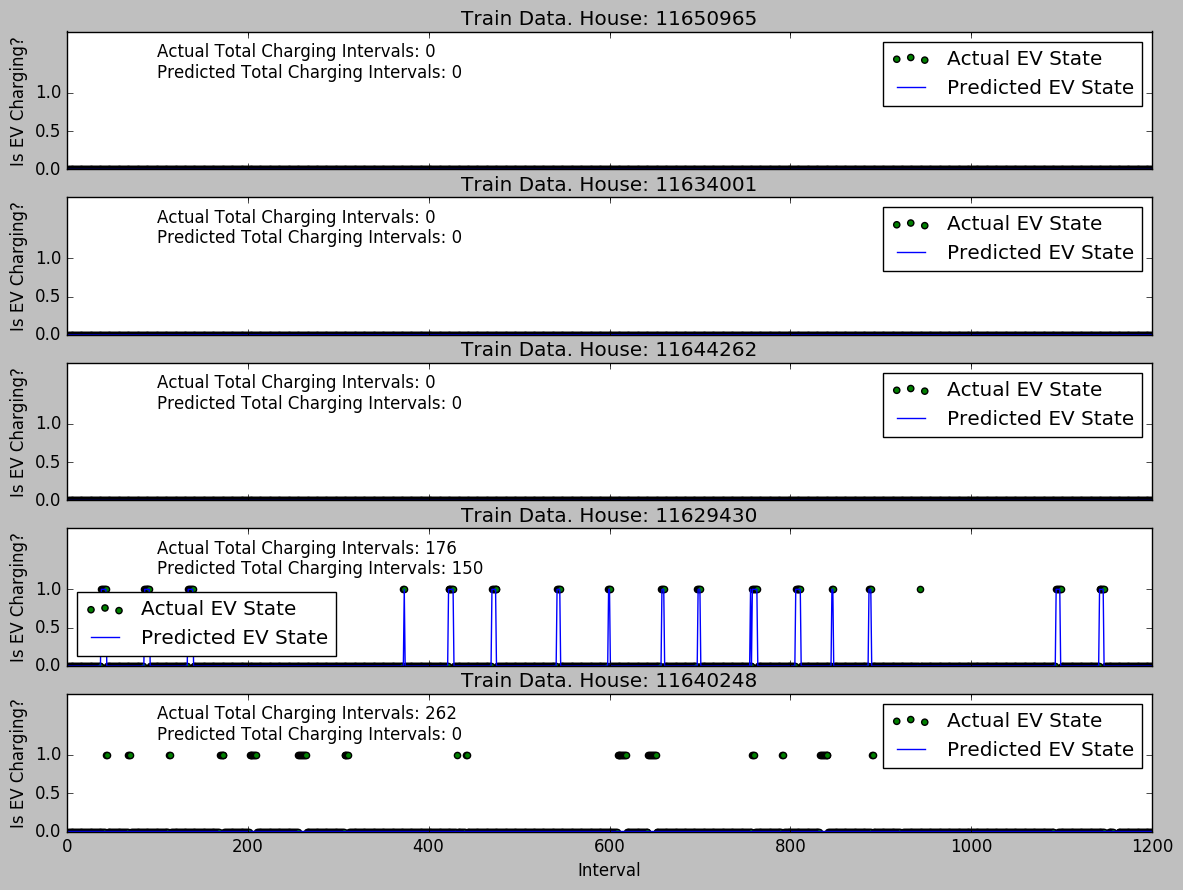

In [16]:
#TRAIN DATA - plot pred vs actual over time, for 5 houses
plt.gcf().clear()
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(14, 10))

#Plot train subplots. Change random seed to get different batch of houses
plot_by_house(axes, 
              labels_true=train_Y['EV Charging Flag'],
              labels_pred=train_preds['EV Charging Flag'] > classification_threshold,
              group_columns=train_preds[['Interval', 'House ID']],
              house_subplots=5,
              plot_intervals=1200, 
              title_prefix='Train Data.',
              random_state = 42)
plt.show()

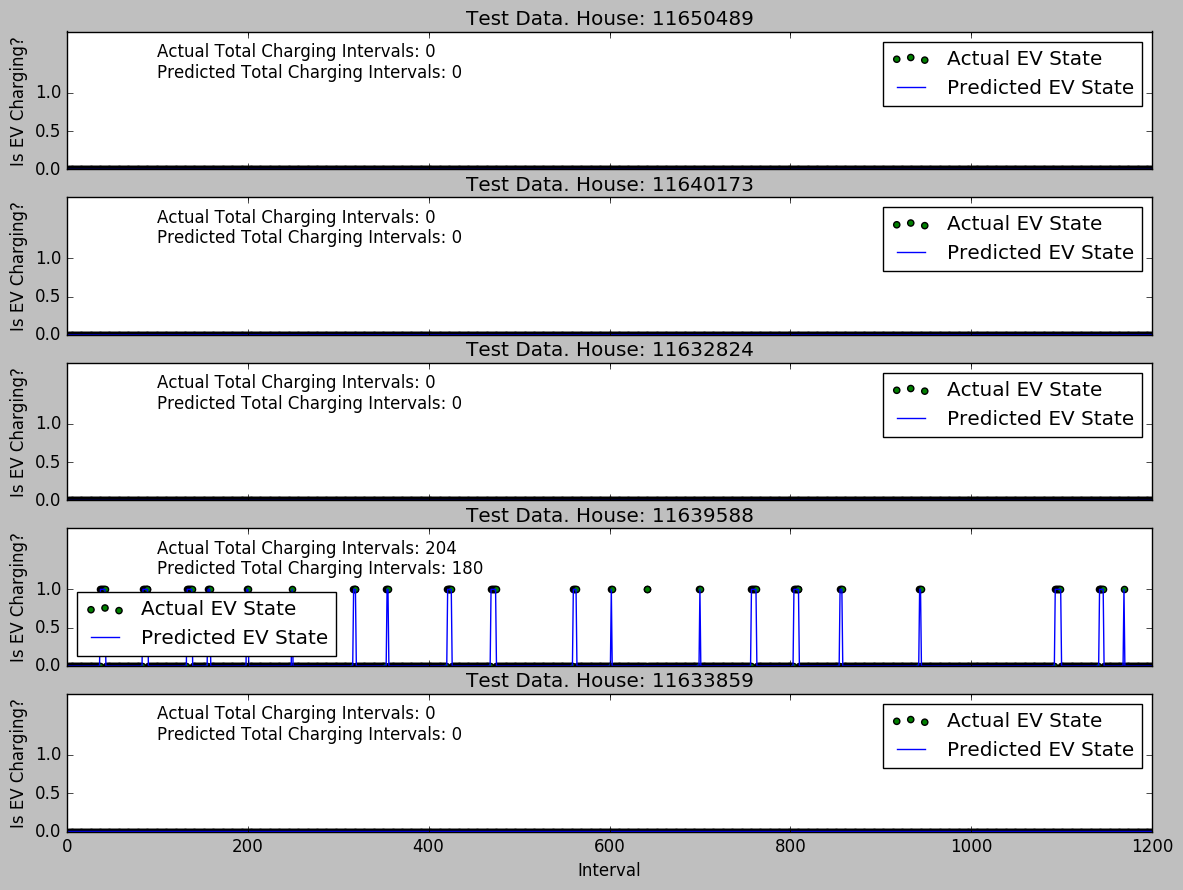

In [18]:
#TEST DATA - plot pred vs actual over time, for 5 houses
plt.gcf().clear()
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(14, 10))

#Plot train subplots. Change random seed to get different batch of houses
plot_by_house(axes, 
              labels_true=test_Y['EV Charging Flag'],
              labels_pred=test_preds['EV Charging Flag'] > classification_threshold,
              group_columns=test_preds[['Interval', 'House ID']],
              house_subplots=5,
              plot_intervals=1200, 
              title_prefix='Test Data.',
              random_state = 42)
plt.show()